# Oregon Site

Lat: 44.57615187732146
Long:  -123.23914850912513
Tilt: 25 degrees
Fixed-Racking, S-facing
Clearance_Height = 34.667 inches
B: 81.667 inches
Collector Width: 132.5 inches
Pitch: 245 inches
Hub_height: 58.167 inches



<a id='step1'></a>

In [1]:
import os
from pathlib import Path

testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' / 'AgriPV_Oregon_A')
if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\AgriPV_Oregon_A


In [2]:
from bifacial_radiance import *   
import numpy as np
import datetime

In [3]:
lat = 44.57615187732146
lon = -123.23914850912513
tilt = 25 # degrees
sazm = 180 # degrees (south)
numpanels = 2
albedo = 0.2  #'grass'     # ground albedo

# Three sites differences:
cws = [3.3655, 3.3655, 3.9624] # m
clearance_heights = [0.8805418, 0.9482582, 0.6985] # m
pitchs = [6.223, 8.4201, 6.8453]  # m 

ys = np.divide(cws,numpanels)
print("Panel length" , ys)
x = 1


Panel length [1.68275 1.68275 1.9812 ]


In [5]:
demo = RadianceObj('Oregon', path=testfolder)  # Create a RadianceObj 'object'
demo.setGround(albedo) # input albedo number or material name like 'concrete'.  To see options, run this without any input.
epwfile = demo.getEPW(lat, lon) # NJ lat/lon 40.0583° N, 74.4057
metdata = demo.readWeatherFile(epwfile, starttime=startdt, endtime=enddt, coerce_year=2021) # read in the EPW weather data from above
startdt =datetime.datetime(2021,5,1,0)
enddt = datetime.datetime(2021,9,30,23)
metdata = demo.readWeatherFile(epwfile, starttime=startdt, endtime=enddt, coerce_year=2021) # read in the EPW weather data from above
demo.genCumSky()

path = C:\Users\sayala\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\AgriPV_Oregon_A
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_OR_Corvallis.Muni.AP.726945_TMY3.epw
 ... OK!


## 1. Loop over the different heights

In [14]:
for ii in range(0,3):
    y= ys[ii]
    ch = clearance_heights[ii]
    pitch = pitchs[ii]
    
    moduletype='PV-module'
    module = demo.makeModule(name=moduletype, x=x, y=y, numpanels=numpanels)
    sceneDict = {'tilt':tilt, 'pitch':pitch, 'clearance_height':ch, 'azimuth':sazm, 'nMods':20, 'nRows':7}  
    #starttime = '01_13_11';  endtime = '01_13_12'
    scene = demo.makeScene(module=moduletype, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.
    octfile = demo.makeOct()  # makeOct combines all of the ground, sky and object fil|es into a .oct file.
    # Sensor calculation
    spacingbetweensamples = 0.05  # one sensor every 5 cm
    sensorsy = round(pitch/spacingbetweensamples) -1 # one sensor every 5 cm

    analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
    frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=[1, 9])
    groundscan = frontscan.copy()
    groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
    groundscan['zinc'] = 0   # no tilt necessary. 
    groundscan['yinc'] = spacingbetweensamples   # increasing spacing so it covers all distance between rows
    groundscan['Ny'] = sensorsy   # increasing spacing so it covers all distance between rows

    analysis.analysis(octfile, 'Site_'+str(ii)+'_Module_', frontscan, backscan)  # compare the back vs front irradiance  
    analysis.analysis(octfile, 'Site_'+str(ii)+'_Ground_', frontscan, groundscan)  # compare the back vs front irradiance  


Module Name: PV-module
Module PV-module updated in module.json
Pre-existing .rad file objects\PV-module.rad will be overwritten

Created Oregon.oct
Linescan in process: Site_0_Module__Row4_Module10_Front
Linescan in process: Site_0_Module__Row4_Module10_Back
Saved: results\irr_Site_0_Module__Row4_Module10_Front.csv
Saved: results\irr_Site_0_Module__Row4_Module10_Back.csv
Linescan in process: Site_0_Ground__Row4_Module10_Front
Linescan in process: Site_0_Ground__Row4_Module10_Back
Saved: results\irr_Site_0_Ground__Row4_Module10_Front.csv
Saved: results\irr_Site_0_Ground__Row4_Module10_Back.csv

Module Name: PV-module
Module PV-module updated in module.json
Pre-existing .rad file objects\PV-module.rad will be overwritten

Created Oregon.oct
Linescan in process: Site_1_Module__Row4_Module10_Front
Linescan in process: Site_1_Module__Row4_Module10_Back
Saved: results\irr_Site_1_Module__Row4_Module10_Front.csv
Saved: results\irr_Site_1_Module__Row4_Module10_Back.csv
Linescan in process: Sit

## 2. Plot Bifacial Gain Results

## 3. Plot Heatmaps of the Ground Irradiance

#### First, here is a complicated way to find the maximum of all arrays so all heatmaps are referenced to that value

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [46]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

sns.set(rc={'figure.figsize':(5,5)})

In [33]:
results_BGG=[]
results_G=[]
results_coords= []
for ii in range(0, 3):
    filepvf= os.path.join(testfolder,'results',f'irr_Site_'+str(ii)+'_Module__Row4_Module10_Front.csv')
    filepvb= os.path.join(testfolder,'results',f'irr_Site_'+str(ii)+'_Module__Row4_Module10_Back.csv')
    fileground= os.path.join(testfolder,'results',f'irr_Site_'+str(ii)+'_Ground__Row4_Module10_Back.csv')
    resultsDF = load.read1Result(filepvf)
    resultsDB = load.read1Result(filepvb)
    resultsG = load.read1Result(fileground)
    #resultsDF = load.cleanResult(resultsDF).dropna()
    results_BGG.append(np.round(resultsDB['Wm2Back'].mean()*100/resultsDF['Wm2Front'].mean(),1))
    results_G.append(resultsG['Wm2Back'])
    results_coords.append(resultsG['y'])
    


In [27]:
GHI_season = demo.metdata.ghi.sum()

In [28]:
print("Bifacial Gain Results for Each site", results_BGG)

Bifacial Gain Results for EAch site [7.0, 8.3, 6.1]


Text(0.5, 0, 'Pitch [m]')

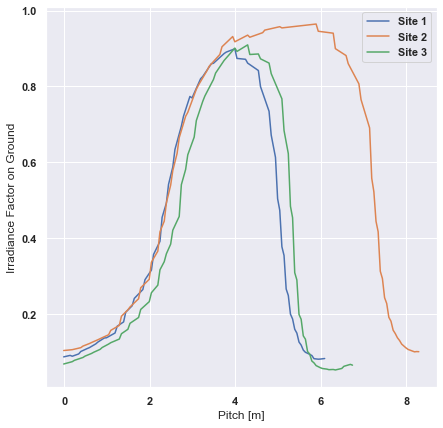

In [48]:
plt.figure(figsize=(7,7))
plt.plot(results_coords[0],results_G[0]/GHI_season, label='Site 1')
plt.plot(results_coords[1],results_G[1]/GHI_season, label='Site 2')
plt.plot(results_coords[2],results_G[2]/GHI_season, label='Site 3')
plt.legend()
plt.ylabel("Irradiance Factor on Ground")
plt.xlabel("Pitch [m]")

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(hub_heights, results_BGG, '.-')
plt.ylabel('Bifacial Gain in Irradiance (BG$_G$) [%]')
plt.xlabel('Hub height [m]')

In [ ]:
maxmax = 0
for hh in range (0, len(hub_heights)):
    for cc in range (0, len(crops)):
        filestarter = "irr_height_"+ str(int(hub_heights[hh]*100))+'cm_'+crops[cc]

        filelist = sorted(os.listdir(os.path.join(testfolder, 'results')))
        prefixed = [filename for filename in filelist if filename.startswith(filestarter)]
        arrayWm2Front = []
        arrayWm2Back = []
        arrayMatFront = []
        arrayMatBack = []
        filenamed = []
        faillist = []

        print('{} files in the directory'.format(filelist.__len__()))
        print('{} groundscan files in the directory'.format(prefixed.__len__()))
        i = 0  # counter to track # files loaded.

        for i in range (0, len(prefixed)-1):
            ind = prefixed[i].split('_')
            #print(" Working on ", filelist[i], locs[ii], Scenario[jj])
            try:
                resultsDF = load.read1Result(os.path.join(testfolder, 'results', prefixed[i]))
                arrayWm2Front.append(list(resultsDF['Wm2Front']))
                arrayWm2Back.append(list(resultsDF['Wm2Back']))
                arrayMatFront.append(list(resultsDF['mattype']))
                arrayMatBack.append(list(resultsDF['rearMat']))
                filenamed.append(prefixed[i])
            except:
                print(" FAILED ", i, prefixed[i])
                faillist.append(prefixed[i])

        resultsdf = pd.DataFrame(list(zip(arrayWm2Front, arrayWm2Back, 
                                          arrayMatFront, arrayMatBack)),
                                 columns = ['br_Wm2Front', 'br_Wm2Back', 
                                            'br_MatFront', 'br_MatBack'])
        resultsdf['filename'] = filenamed
        
        df3 = pd.DataFrame(resultsdf['br_Wm2Front'].to_list())
        reversed_df = df3.T.iloc[::-1]
        
        if df3.max().max() > maxmax:
            maxmax = df3.max().max()


print("MAX Found", maxmax)

Now let's print Results Table and Ground Irradiance Heatmaps:

In [ ]:
for hh in range (0, len(hub_heights)):
    for cc in range (0, len(crops)):
        filestarter = "irr_height_"+ str(int(hub_heights[hh]*100))+'cm_'+crops[cc]

        filelist = sorted(os.listdir(os.path.join(testfolder, 'results')))
        prefixed = [filename for filename in filelist if filename.startswith(filestarter)]
        arrayWm2Front = []
        arrayWm2Back = []
        arrayMatFront = []
        arrayMatBack = []
        filenamed = []
        faillist = []

        i = 0  # counter to track # files loaded.

        for i in range (0, len(prefixed)-1):
            ind = prefixed[i].split('_')
            #print(" Working on ", filelist[i], locs[ii], Scenario[jj])
            try:
                resultsDF = load.read1Result(os.path.join(testfolder, 'results', prefixed[i]))
                arrayWm2Front.append(list(resultsDF['Wm2Front']))
                arrayWm2Back.append(list(resultsDF['Wm2Back']))
                arrayMatFront.append(list(resultsDF['mattype']))
                arrayMatBack.append(list(resultsDF['rearMat']))
                filenamed.append(prefixed[i])
            except:
                print(" FAILED ", i, prefixed[i])
                faillist.append(prefixed[i])

        resultsdf = pd.DataFrame(list(zip(arrayWm2Front, arrayWm2Back, 
                                          arrayMatFront, arrayMatBack)),
                                 columns = ['br_Wm2Front', 'br_Wm2Back', 
                                            'br_MatFront', 'br_MatBack'])
        resultsdf['filename'] = filenamed
        
        df3 = pd.DataFrame(resultsdf['br_Wm2Front'].to_list())
        reversed_df = df3.T.iloc[::-1]
            
        plt.figure()
        ax = sns.heatmap(reversed_df/maxmax, vmin=0, vmax=1)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel('')  
        ax.set_xlabel('')
        mytitle = 'Crop: '+crops[cc]+', Hub Height '+str(hub_heights[hh])
        ax.set_title(mytitle)
        
        print(mytitle, "MAX irradiance", round(df3.max().max()/1000,1), " kW/m2; Min irradiance", round(df3.min().min()/1000,1), "kW/m2")

print("")